In [119]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torchvision import models as torch_models1
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import openpyxl
import xlsxwriter
from collections import namedtuple
import os
import random
import math
from PIL import Image
from scipy import interp
from sklearn.model_selection import KFold, StratifiedKFold
import pandas as pd
from torch.utils.data import Sampler, BatchSampler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, recall_score, precision_score, confusion_matrix, precision_recall_curve
from torch.autograd import Variable
import logging
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
from sklearn.metrics import auc as calc_auc
import math

In [120]:
SEED = 1234
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [121]:
train_dataset = pd.read_excel('/home/ldap_howard/script/MSI_CRC_DX_0307.xlsx',sheet_name='MSIHMSS')
train_x = train_dataset['Patients'].values
train_y = train_dataset['isMSIH']
train_y = train_y.values

In [122]:
kf = StratifiedKFold(n_splits=4, shuffle=True, random_state=5)

In [123]:
def npy_loader(path):
    x = np.load(path,allow_pickle=True).item()
    x_im = torch.from_numpy(x['features'])
    return x_im

In [124]:
class Dataset_loader(Dataset):
    def __init__(self, x, y):
        super().__init__()
        self.x = x
        self.y = y
        self.path = '/ORCA_lake/TCGA-COAD/feature/CRC_resnet0307/'
        
    def __len__(self):
        return len(self.x)   
    
    def __getitem__(self, idx):
        image_path = os.path.join(self.path, self.x[idx]+'.npy')

        return image_path, self.y[idx]

In [125]:
class Attention(nn.Module):
    def __init__(self, L=2048, D=1024, dropout=True, n_classes=2, top_k=1):
        super(Attention, self).__init__()
        self.L = L
        self.D = D
        self.K = 1

        self.layer1 = nn.Linear(self.L, self.D)
        if dropout:
            self.attention_V = nn.Sequential(nn.Linear(self.D, 512), nn.Tanh(), nn.Dropout(0.25))
            self.attention_U = nn.Sequential(nn.Linear(self.D, 512), nn.Sigmoid(), nn.Dropout(0.25))
        else:
            self.attention_V = nn.Sequential(nn.Linear(self.D, 512), nn.Tanh())
            self.attention_U = nn.Sequential(nn.Linear(self.D, 512), nn.Sigmoid())

        self.attention_weights = nn.Linear(512, self.K)

        self.classifier = nn.Sequential(nn.Linear(self.D, 1024),
                                        nn.ReLU(),
                                        nn.Dropout(0.25),
                                        nn.Linear(1024, 512),
                                        nn.ReLU(),
                                        nn.Linear(512,2),
                                        nn.Sigmoid())

        self.top_k = top_k

    def forward(self, x):
        x = self.layer1(x)
        A_V = self.attention_V(x)  # NxD
        A_U = self.attention_U(x)
        A = self.attention_weights(A_V*A_U)
        A = torch.transpose(A, 1, 0)  # KxN
        A = F.softmax(A, dim=1)  # softmax over N
        M = torch.mm(A, x)  # KxL

        logits = self.classifier(M)
        y_probs = F.softmax(logits, dim=1)
        top_instance_idx = torch.topk(y_probs[:, 1], self.top_k, dim=0)[1].view(1, )
        top_instance = torch.index_select(logits, dim=0, index=top_instance_idx)
        Y_hat = torch.topk(top_instance, 1, dim=1)[1]
        Y_prob = F.softmax(top_instance, dim=1)
        results_dict = {}
        results_dict.update({'logits': top_instance, 'Y_prob': Y_prob, 'Y_hat': Y_hat, 'A': A})
        return results_dict

    def relocate(self):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.classifier.to(device)
        self.attention_V.to(device)
        self.attention_U.to(device)
        self.attention_weights.to(device)

In [126]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""

    def __init__(self, patience=40, stop_epoch=100, verbose=False):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 20
            stop_epoch (int): Earliest epoch possible for stopping
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
        """
        self.patience = patience
        self.stop_epoch = stop_epoch
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_max = np.Inf

    def __call__(self, epoch, val_loss, model, ckpt_name='checkpoint.pt'):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model, ckpt_name)
        elif score < self.best_score:
            self.counter += 1
            logging.info(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience and epoch > self.stop_epoch:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model, ckpt_name)
            self.counter = 0

    def save_checkpoint(self, early_stopping, model, ckpt_name):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            logging.info(
                f'Validation loss decreased ({self.val_loss_max:.6f} --> {early_stopping:.6f}).  Saving model ...')
        print("Save model!!!!!!!!!!!")
        torch.save(model.state_dict(), ckpt_name)
        self.val_loss_max = early_stopping

In [127]:
def calculate_error(Y_hat, Y):
    error = 1. - Y_hat.float().eq(Y.float()).float().mean().item()
    return error

In [128]:
def summary_to_excel(fold, loader_name, label_list, probs_list, y_hat_list, accuracy, specificity, sensitivity, precision, f1_score, cls_auc, auprc):
    df = pd.DataFrame(
        {
            "Patients": loader_name,
            "labels": label_list,
            "probs": probs_list,
            "y_hat": y_hat_list,
            "Accuracy" : accuracy,
            "Specificity": specificity,
            "Sensitivity":sensitivity,
            "Precision": precision,
            "F1-score": f1_score,
            "Auc": cls_auc,
            "AUPRC": auprc,
        }
    )

    if fold == 0:
        with pd.ExcelWriter('./summary/attention_hover/MSI_0307CV28_ssl.xlsx', engine='openpyxl') as writer:
            df.to_excel(writer, sheet_name='Sheet0', index=False)
    else:
        with pd.ExcelWriter('./summary/attention_hover/MSI_0307CV28_ssl.xlsx', engine='openpyxl', mode='a') as writer:
            df.to_excel(writer, sheet_name='Sheet'+str(fold), index=False)

    print("Patients data is successfully written into Excel File")

In [129]:
def summary(model, loader, n_classes, fold):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    #cls_logger = Accuracy_Logger(n_classes=n_classes)
    model.eval()
    cls_test_error = 0.
    cls_test_loss = 0.

    all_cls_probs = np.zeros((len(loader), n_classes))
    all_cls_labels = np.zeros(len(loader))
    all_cls_y_hats = np.zeros(len(loader))

    patient_results = {}
    
    loader_name = []
    for batch_idx, (npy_dir, label) in enumerate(loader):
        data = npy_loader(npy_dir[0]).to(device)
        label = label.to(device)
        with torch.no_grad():
            results_dict = model(data)

        logits, Y_prob, Y_hat = results_dict['logits'], results_dict['Y_prob'], results_dict['Y_hat']
        loader_name.append(npy_dir[0])

        #cls_logger.log(Y_hat, label)
        cls_probs = Y_prob.cpu().numpy()
        cls_Yhats = Y_hat.cpu().numpy()
        all_cls_probs[batch_idx] = cls_probs
        all_cls_labels[batch_idx] = label.item()
        all_cls_y_hats[batch_idx] = cls_Yhats.item()

        cls_error = calculate_error(Y_hat, label)
        cls_test_error += cls_error

    cls_test_error /= len(loader)

    if n_classes == 2:
        print(all_cls_labels)
        print(all_cls_y_hats)
        tn, fp, fn, tp = confusion_matrix(all_cls_labels, all_cls_y_hats, labels=[0, 1]).ravel()
        accuracy = (tp+tn)/(tp+tn+fp+fn)
        sensitivity = tp/(tp+fn)
        specificity = tn/(tn+fp)
        recall = tp/(tp+fn)
        precision = tp/(tp+fp)
        f1_score = 2 * precision * recall / (precision + recall)
        try:
            cls_auc = roc_auc_score(all_cls_labels, all_cls_probs[:, 1])
            precision1, recall1, _ = precision_recall_curve(all_cls_labels,all_cls_probs[:,1])
            auprc = calc_auc(recall1, precision1)
        except:
            cls_auc = 'nan'
            auprc = 'nan'
        print("Accuracy: "+str(accuracy))
        print("Specificity: "+str(specificity))
        print("Sensitivity: "+str(sensitivity))
        print("Recall: "+str(recall))
        print("Precision: "+str(precision))
        print("F1-score: "+str(f1_score))
        print("Auc: "+str(cls_auc))
        print("AUPRC: "+str(auprc))

        summary_to_excel(fold, loader_name, all_cls_labels, all_cls_probs[:,1], all_cls_y_hats, 
                         accuracy, specificity, sensitivity, precision, f1_score, cls_auc, auprc)
    else:
        cls_auc = roc_auc_score(all_cls_labels, all_cls_probs[:,1], multi_class='ovr')

    return patient_results, cls_test_error, cls_auc, all_cls_labels, all_cls_probs[:,1]

In [130]:
def plot_loss_curve(train_loss, valid_loss, fold):
    title = 'MSI AttMIL fold' + str(fold+1) + ' loss curve'
    plt.plot(train_loss, label='train loss')
    plt.plot(valid_loss, label='validation loss')
    plt.xlabel('Epoch', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.title(title, fontsize=18)
    plt.legend(fontsize=12)
    plt.savefig('/home/ldap_howard/script/summary/attention_hover/loss_fold'+str(fold)+'_clam.png')
    plt.show()

In [131]:
def train_loop(epoch, model, loader, optimizer, n_classes, writer=None, loss_fn=None):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.train()
    #cls_logger = Accuracy_Logger(n_classes=n_classes)
    cls_train_error = 0.
    cls_train_loss = 0.
    for batch_idx, (npy_dir, label) in enumerate(loader):
        data = npy_loader(npy_dir[0]).to(device)
        label = label.to(device)
        num = data.shape[0]

        results_dict = model(data)
        logits, Y_prob, Y_hat = results_dict['logits'], results_dict['Y_prob'], results_dict['Y_hat']

        #cls_logger.log(Y_hat, label)

        cls_loss = loss_fn(logits, label)
        cls_loss_value = cls_loss.item()

        cls_train_loss += cls_loss_value
        cls_error = calculate_error(Y_hat, label)
        cls_train_error += cls_error

        # backward pass
        cls_loss.backward()
        # step
        optimizer.step()
        optimizer.zero_grad()

    # calculate loss and error for epoch
    cls_train_loss /= len(loader)
    cls_train_error /= len(loader)

    #logging.info(
    #    'Epoch: {}, cls train_loss: {:.4f}, cls train_error: {:.4f}'.format(epoch, cls_train_loss, cls_train_error))
    #for i in range(n_classes):
    #    acc, correct, count = cls_logger.get_summary(i)
    #    logging.info('class {}: tpr {:.4f}, correct {}/{}'.format(i, acc, correct, count))
    #    if writer:
    #        writer.add_scalar('train/class_{}_tpr'.format(i), acc, epoch)

    #if writer:
    #    writer.add_scalar('train/cls_loss', cls_train_loss, epoch)
    #    writer.add_scalar('train/cls_error', cls_train_error, epoch)
    return cls_train_loss

In [132]:
def validate(model_name, epoch, model, loader, n_classes, early_stopping=None, writer=None, loss_fn=None, results_dir=None):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    #cls_logger = Accuracy_Logger(n_classes=n_classes)
    cls_val_error = 0.
    cls_val_loss = 0.

    cls_probs = np.zeros((len(loader), n_classes))
    cls_labels = np.zeros(len(loader))
    all_labels = []
    all_outputs = []

    with torch.no_grad():
        for batch_idx, (npy_dir, label) in enumerate(loader):
            data = npy_loader(npy_dir[0]).to(device)
            label = label.to(device)
            num = data.shape[0]
            
            results_dict = model(data)
            logits, Y_prob, Y_hat = results_dict['logits'], results_dict['Y_prob'], results_dict['Y_hat']
            del results_dict

            #cls_logger.log(Y_hat, label)

            cls_loss = loss_fn(logits, label)
            cls_loss_value = cls_loss.item()

            cls_probs[batch_idx] = Y_prob.cpu().numpy()
            cls_labels[batch_idx] = label.item()

            cls_val_loss += cls_loss_value
            cls_error = calculate_error(Y_hat, label)
            
            cls_val_error += cls_error

            all_labels.append(label.detach().cpu().numpy()[0])
            all_outputs.append(Y_prob[0][1].detach().cpu().tolist())

    cls_val_error /= len(loader)
    cls_val_loss /= len(loader)

    print("cls val loss: " + str(cls_val_loss))

    if n_classes == 2:
        cls_auc = roc_auc_score(cls_labels, cls_probs[:, 1])
        precision1, recall1, _ = precision_recall_curve(cls_labels,cls_probs[:, 1])
        cls_auprc = calc_auc(recall1, precision1)     
        cls_aucs = []
    else:
        cls_aucs = []
        binary_labels = label_binarize(cls_labels, classes=[i for i in range(n_classes)])
        for class_idx in range(n_classes):
            if class_idx in cls_labels:
                fpr, tpr, _ = roc_curve(binary_labels[:, class_idx], cls_probs[:, class_idx])
                cls_aucs.append(calc_auc(fpr, tpr))
            else:
                cls_aucs.append(float('nan'))

        cls_auc = np.nanmean(np.array(cls_aucs))
    print("cls_auc: " + str(cls_auc))
    print("cls_auprc: " + str(cls_auprc))


    #if writer:
    #    writer.add_scalar('val/cls_loss', cls_val_loss, epoch)
    #    writer.add_scalar('val/cls_auc', cls_auc, epoch)
    #    writer.add_scalar('val/cls_error', cls_val_error, epoch)

    #logging.info(
    #    '\nVal Set, cls val_loss: {:.4f}, cls val_error: {:.4f}, cls auc: {:.4f}'.format(cls_val_loss, cls_val_error,
    #                                                                                     cls_auc))
    #for i in range(n_classes):
    #    acc, correct, count = cls_logger.get_summary(i)
    #    logging.info('class {}: tpr {}, correct {}/{}'.format(i, acc, correct, count))
    #    if writer:
    #        writer.add_scalar('val/class_{}_tpr'.format(i), acc, epoch)
    #print(model_name)

    if early_stopping:
        assert results_dir
        early_stopping(epoch, cls_val_loss, model,
                       ckpt_name=os.path.join(results_dir, model_name))

        if early_stopping.early_stop:
            logging.info("Early stopping")
            return cls_val_loss, True

    return cls_val_loss, False

In [133]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='none'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def forward(self, logits, label):
        ce_loss = F.cross_entropy(logits,label, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss

        if self.reduction == 'mean':
            return torch.mean(focal_loss)
        elif self.reduction == 'sum':
            return torch.sum(focal_loss)
        else:
            return focal_loss

In [134]:
train_data = Dataset_loader(train_x, train_y)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
early_stopping = None
writer = None

cuda


FOLD 0
--------------------------------
0
cls val loss: 0.1141076097367229
cls_auc: 0.7114035087719298
cls_auprc: 0.30287238881560025
Save model!!!!!!!!!!!
1
cls val loss: 0.11197301933726111
cls_auc: 0.7859649122807018
cls_auprc: 0.5246420679354892
Save model!!!!!!!!!!!
2
cls val loss: 0.11103025426740175
cls_auc: 0.8228070175438597
cls_auprc: 0.6270048831897209
Save model!!!!!!!!!!!
3
cls val loss: 0.11067901326568572
cls_auc: 0.8096491228070175
cls_auprc: 0.5963665405397894
Save model!!!!!!!!!!!
4
cls val loss: 0.10706133334027541
cls_auc: 0.8087719298245614
cls_auprc: 0.5733509247355656
Save model!!!!!!!!!!!
5
cls val loss: 0.10255131665821914
cls_auc: 0.8105263157894737
cls_auprc: 0.5871670426697356
Save model!!!!!!!!!!!
6
cls val loss: 0.11066639476588794
cls_auc: 0.8228070175438597
cls_auprc: 0.5406333130456409
7
cls val loss: 0.10280178094303215
cls_auc: 0.8412280701754385
cls_auprc: 0.5701316412947187
8
cls val loss: 0.09812550144372406
cls_auc: 0.8456140350877193
cls_auprc: 0

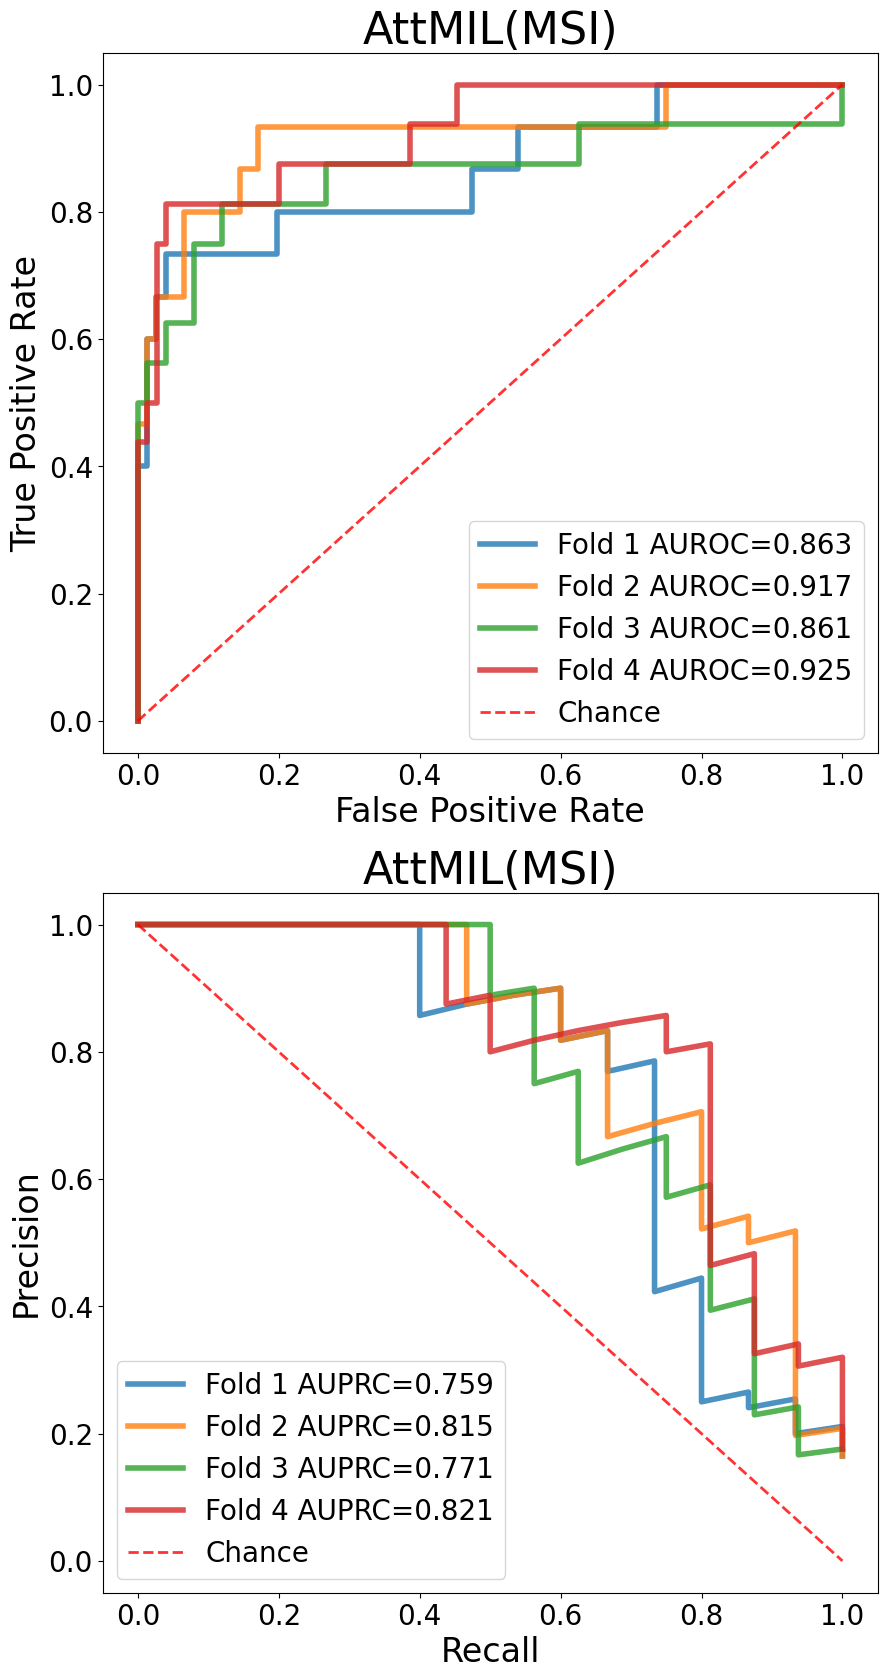

In [135]:
i = 0
tprs = []
aucs = []
aucs = []
auprcs = []
precisions = []
y_real = []
y_probs = []
mean_fpr = np.linspace(0,1,100)
mean_recall = np.linspace(0,1,100)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,20))
for fold, (train_ids, valid_ids) in enumerate(kf.split(train_x, train_y)):
    print(f'FOLD {fold}')
    print('--------------------------------')
    
    model_name = './model/MSI_0307CV28_fold'+str(fold)+'_ssl_checkpoint.pt'
    train_fold = torch.utils.data.Subset(train_data, train_ids)
    valid_fold = torch.utils.data.Subset(train_data, valid_ids)

    train_loader = DataLoader(train_fold, batch_size=1, shuffle = True)
    valid_loader = DataLoader(valid_fold, batch_size=1)
    
    model = Attention()
    model.to(device)

    weights = torch.FloatTensor([0.2,0.8]).to(device)
    loss_fn = FocalLoss().to(device)
    #loss_fn = nn.CrossEntropyLoss().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.00008, betas=(0.9, 0.999), weight_decay=0.003)

    writer = None
    early_stopping = EarlyStopping(patience=30, stop_epoch=100, verbose=True)

    results_dir = '/home/ldap_howard/script/'
    cur = 'model'
    train_loss = []
    valid_loss = []
    for epoch in range(1000):
        print(epoch)
        train_epoch_loss = train_loop(epoch, model, train_loader, optimizer, 2, writer, loss_fn)
        valid_epoch_loss, stop = validate(model_name, epoch, model, valid_loader, 2,
                                early_stopping, writer, loss_fn, results_dir)
        
        train_loss.append(train_epoch_loss)
        valid_loss.append(valid_epoch_loss)

        if stop:
            break
    
    if early_stopping:
        print("EarlyStopping")
        model.load_state_dict(torch.load(os.path.join(results_dir, model_name))) #"s_{}_checkpoint.pt".format(cur))))
    else:
        torch.save(model.state_dict(), os.path.join(results_dir, model_name)) #"s_{}_{}_checkpoint.pt".format(cur)))

    _, cls_val_error, cls_val_auc, cls_labels, cls_probs = summary(model, valid_loader, 2, fold)
    fpr, tpr, t = roc_curve(cls_labels, cls_probs)
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    roc_auc = calc_auc(fpr, tpr)
    aucs.append(roc_auc)

    lab_fold = 'Fold %d AUROC=%.3f' % (i+1, roc_auc)
    ax1.plot(fpr, tpr, alpha=0.8, lw=4, label=lab_fold)


    precision_fold, recall_fold, _ = precision_recall_curve(cls_labels, cls_probs)
    precision_fold, recall_fold = precision_fold[::-1], recall_fold[::-1]
    precisions.append(np.interp(mean_recall, recall_fold, precision_fold))
    auprc = calc_auc(recall_fold, precision_fold)
    auprcs.append(auprc)
    y_real.append(cls_labels)
    y_probs.append(cls_probs)
    
    lab_fold = 'Fold %d AUPRC=%.3f' % (i+1, auprc)
    ax2.plot(recall_fold, precision_fold, alpha=0.8, lw=4, label=lab_fold)
    i=i+1
    logging.info('Cls Val error: {:.4f}, Cls ROC AUC: {:.4f}'.format(cls_val_error, cls_val_auc))
    print("Validation acc: " + str(cls_val_auc))
    print("validation error: " + str(cls_val_error))

    #plot_loss_curve(train_loss, valid_loss, fold)


ax1.set_title('AUROC',fontsize=20)
ax1.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
ax1.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"ROC curves",
)
ax1.set_xticks(np.arange(0, 1.1, 0.2))
ax1.set_yticks(np.arange(0, 1.1, 0.2))
ax1.tick_params(axis='both', which='major', labelsize=20)
ax1.set_xlabel("False Positive Rate", fontsize=24)
ax1.set_ylabel("True Positive Rate", fontsize=24)
ax1.set_title("AttMIL(MSI)", fontsize=32)
ax1.legend(loc="lower right", fontsize = 20)

ax2.set_title('AUPRC',fontsize=20)
ax2.plot([0, 1], [1, 0], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
ax2.set(
    xlabel="Recall",
    ylabel="Precision",
    title=f"PR curves",
)
ax2.set_xticks(np.arange(0, 1.1, 0.2))
ax2.set_yticks(np.arange(0, 1.1, 0.2))
ax2.tick_params(axis='both', which='major', labelsize=20)
ax2.set_xlabel("Recall", fontsize=24)
ax2.set_ylabel("Precision", fontsize=24)
ax2.set_title("AttMIL(MSI)", fontsize=32)
ax2.legend(loc='lower left', fontsize=20)

plt.show()
fig.savefig('/home/ldap_howard/script/summary/attention_hover/MSI_pr_curve.png')

NA

In [38]:
class CRC_NA_loader(Dataset):
    def __init__(self, x, y):
        super().__init__()
        self.x = x
        self.y = y
        self.path = '/ORCA_lake/TCGA-COAD/feature/CRC_resnet0307/'
        
    def __len__(self):
        return len(self.x)   
    
    def __getitem__(self, idx):
        image_path = os.path.join(self.path, self.x[idx]+'.npy')

        return image_path, self.y[idx]

In [42]:
CRC_dataset = pd.read_excel('/home/ldap_howard/script/MSI_CRC_DX_0307_NA.xlsx',sheet_name='MSIHMSS')
CRC_x = CRC_dataset['Patients'].values
CRC_y = CRC_dataset['isMSIH'].values
CRC_data = CRC_NA_loader(CRC_x, CRC_y)
CRC_loader = DataLoader(CRC_data, batch_size=1)

In [43]:
model = Attention().to(device)
model.load_state_dict(torch.load('/home/ldap_howard/script/model/MSI_0307CV1_fold3_ssl_checkpoint.pt'))

<All keys matched successfully>

In [44]:
summary(model, CRC_loader, 2, 'CRC_NA')

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Accuracy: 0.855072463768116
Specificity: 0.9482758620689655
Sensitivity: 0.36363636363636365
Recall: 0.36363636363636365
Precision: 0.5714285714285714
F1-scor

ValueError: Sheet 'SheetCRC_NA' already exists and if_sheet_exists is set to 'error'.

PAIP

In [56]:
class PAIP_loader(Dataset):
    def __init__(self, x, y):
        super().__init__()
        self.x = x
        self.y = y
        self.path = '/ORCA_lake/TCGA-COAD/feature/PAIP_0307/'
        
    def __len__(self):
        return len(self.x)   
    
    def __getitem__(self, idx):
        image_path = os.path.join(self.path, self.x[idx]+'.npy')

        return image_path, self.y[idx]

In [57]:
PAIP_dataset = pd.read_excel('/home/ldap_howard/script/MSI_PAIP.xlsx')
PAIP_x = PAIP_dataset['Patients'].values
PAIP_y = PAIP_dataset['isMSIH'].values
PAIP_data = PAIP_loader(PAIP_x, PAIP_y)
PAIP_loader = DataLoader(PAIP_data, batch_size=1)

In [58]:
model = Attention().to(device)
model.load_state_dict(torch.load('/home/ldap_howard/script/model/MSI_0307CV21_fold3_ssl_checkpoint.pt'))

<All keys matched successfully>

In [59]:
summary(model, PAIP_loader, 2, 'PAIP')

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Accuracy: 0.8297872340425532
Specificity: 1.0
Sensitivity: 0.3333333333333333
Recall: 0.3333333333333333
Precision: 1.0
F1-score: 0.5
Auc: 0.969047619047619
AUPRC: 0.9048100048100048
Patients data is successfully written into Excel File


({},
 0.1702127659574468,
 0.969047619047619,
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0.53892624, 0.49248475, 0.42168018, 0.59136367, 0.41033408,
        0.29946417, 0.5393917 , 0.39545286, 0.29944634, 0.45209393,
        0.44380662, 0.55514121, 0.28012162, 0.27927318, 0.29657158,
        0.28123891, 0.28301772, 0.2853184 , 0.27722919, 0.45823503,
        0.29495266, 0.29890105, 0.28157061, 0.29840708, 0.29659107,
        0.27652138, 0.27558857, 0.27734515, 0.30363461, 0.27860677,
        0.28591061, 0.29356712, 0.27808779, 0.28382093, 0.27198797,
        0.30716482, 0.28551593, 0.27757701, 0.28861675, 0.27586401,
        0.28457338, 0.29116246, 0.27728379, 0.27551463, 0.28655213,
        0.31514007, 0.28130618]))

CPTAC

In [60]:
class CPTAC_loader(Dataset):
    def __init__(self, x, y):
        super().__init__()
        self.x = x
        self.y = y
        self.path = '/ORCA_lake/TCGA-COAD/feature/CPTAC_0307/'
        
    def __len__(self):
        return len(self.x)   
    
    def __getitem__(self, idx):
        image_path = os.path.join(self.path, self.x[idx]+'.npy')

        return image_path, self.y[idx]

In [61]:
CPTAC_dataset = pd.read_excel('/home/ldap_howard/script/MSI_CPTAC_0307.xlsx')
CPTAC_x = CPTAC_dataset['Patients'].values
CPTAC_y = CPTAC_dataset['isMSIH'].values
CPTAC_data = CPTAC_loader(CPTAC_x, CPTAC_y)
CPTAC_loader = DataLoader(CPTAC_data, batch_size=1)

In [62]:
model = Attention().to(device)
model.load_state_dict(torch.load('/home/ldap_howard/script/model/MSI_0307CV21_fold3_ssl_checkpoint.pt'))

<All keys matched successfully>

In [63]:
summary(model, CPTAC_loader, 2, 'CPTAC')

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
[1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1.
 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1.
 1. 1. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 1. 

({},
 0.19090909090909092,
 0.810096153846154,
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0